**Changing the directory**

In [ ]:
cd '/content/drive/MyDrive/NasrAbadi/EEG Time Series /Four Sec without Overlap/With Baseline/Simple Train Test Split'

/content/drive/MyDrive/NasrAbadi/EEG Time Series /Four Sec without Overlap/With Baseline/Simple Train Test Split


**Installing Required Packages**

In [ ]:
!pip install scikit-optimize
!pip install pyriemann

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Change the channels to first**

In [ ]:
from tensorflow.keras import backend as K
K.set_image_data_format('channels_first')

**Building the Model**

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import utils as np_utils
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout, multiply,LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import math
import gc
from numpy import mean
from numpy import std
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import cross_val_score
from skopt.utils import use_named_args
from skopt import gp_minimize
import tensorflow as tf
import numpy as np

def create_model(kernelLength = 32, nb_classes = 2, Chans = 19, Samples = 512,   
                dropoutRate = 0.5 , F1 = 8, D = 2, F2 = 16, norm_rate = 0.25,
                dropoutType = 'Dropout', optimizer_type = 'Adam', lr=0.0005, **kwargs):
  
  K.clear_session()
  gc.collect()
  if dropoutType == 'SpatialDropout2D':
      dropoutType = SpatialDropout2D
  elif dropoutType == 'Dropout':
      dropoutType = Dropout
  else:
      raise ValueError('dropoutType must be one of SpatialDropout2D '
                        'or Dropout, passed as a string.')
  
  input1   = Input(shape = (1, Chans, Samples))

  ##################################################################
  block1       = Conv2D(F1, (1, kernelLength), padding = 'same',
                                  input_shape = (1, Chans, Samples),
                                  use_bias = False)(input1)
  block1       = BatchNormalization(axis = 1)(block1)
  block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                  depth_multiplier = D,
                                  depthwise_constraint = max_norm(1.))(block1)
  block1       = BatchNormalization(axis = 1)(block1)
  block1       = Activation('elu')(block1)
  block1       = AveragePooling2D((1, 4))(block1)
  block1       = dropoutType(dropoutRate)(block1)
  
  block2       = SeparableConv2D(F2, (1, 16),
                                  use_bias = False, padding = 'same')(block1)
  block2       = BatchNormalization(axis = 1)(block2)
  block2       = Activation('elu')(block2)
  block2       = AveragePooling2D((1, 8))(block2)
  block2       = dropoutType(dropoutRate)(block2)
      
  flatten      = Flatten(name = 'flatten')(block2)
  
  dense        = Dense(nb_classes, name = 'dense', 
                        kernel_constraint = max_norm(norm_rate))(flatten)
  softmax      = Activation('softmax', name = 'softmax')(dense)
  
  model        = Model(inputs=input1, outputs=softmax)
  if optimizer_type == 'Adam':
    optimizer = Adam(learning_rate = lr)
  if optimizer_type == 'Adamax':
    optimizer = Adamax(learning_rate = lr)
  if optimizer_type == 'AdamW':
    optimizer = AdamW(learning_rate = lr)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['accuracy'])
  return model
####################################################################################################
def TactileNet(nb_classes=2, Chans = 19, Samples = 512, kernLength = 16,
               F1 = 64, D=4, dropoutRate = 0.5,dropoutType = 'Dropout',
               optimizer_type = 'Adam', lr=0.001, **kwargs):


  if dropoutType == 'SpatialDropout2D':
      dropoutType = SpatialDropout2D
  elif dropoutType == 'Dropout':
      dropoutType = Dropout
  else:
      raise ValueError('dropoutType must be one of SpatialDropout2D '
                        'or Dropout, passed as a string.')
  #EEGNet alike part
  input1       = Input(shape = (1, Chans, Samples))
  block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                  input_shape = (1, Chans, Samples),
                                  use_bias = False)(input1)
  block1       = BatchNormalization(axis = 1 ,trainable = True)(block1)
  block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                  depth_multiplier = D,
                                  depthwise_constraint = max_norm(1.))(block1)
  block1       = BatchNormalization( axis = 1, trainable = True)(block1)
  block1       = Activation('elu')(block1)
  block1       = AveragePooling2D((1, 2))(block1)
  block1       = dropoutType(dropoutRate)(block1)

  ###############################################
  #first tower
  sub_block1   = Conv2D(64, (1, 1), padding = 'same',use_bias = False)(block1)
  sub_block1   = SeparableConv2D(128, (1, 128), padding = 'same',use_bias = False)(sub_block1)
  sub_block1   = AveragePooling2D((1, 2), padding = 'same')(sub_block1)
  #second tower
  sub_block2   = Conv2D(16, (1, 1), padding = 'same',use_bias = False)(block1)
  sub_block2   = SeparableConv2D(32, (1, 256), padding = 'same',use_bias = False)(sub_block2)
  sub_block2  = AveragePooling2D((1, 2), padding = 'same')(sub_block2)
  #third tower
  sub_block3   = Conv2D(64, (1, 1), padding = 'same', strides=(1,2), use_bias = False)(block1)
  #forth tower
  sub_block4   = AveragePooling2D((1, 2), padding = 'same')(block1)
  sub_block4   = Conv2D(32, (1, 1), padding = 'same',use_bias = False)(sub_block4)
  #concatenation
  concat       = concatenate([sub_block1, sub_block2, sub_block4, sub_block3],axis=1)
  
  #last tower
  block2       = BatchNormalization( axis = 1, trainable = True)(concat)
  block2       = Activation('elu')(block2)
  #SENEt block
  squeeze1     = GlobalAveragePooling2D()(block2)
  excitation1  = Dense(16, activation='relu')(squeeze1)
  excitation1  = Dense(256, activation='sigmoid')(excitation1)
  block2       = Permute(dims=(2,3,1))(block2)
  excitation1  = multiply([block2, excitation1])
  excitation1  = Permute(dims=(3,1,2))(excitation1)

  block2       = SeparableConv2D(256, (1, 64), padding = 'same',use_bias = False)(excitation1)
  block2       = BatchNormalization( axis = 1, trainable = True)(block2)
  block2       = Activation('elu')(block2)
  #SENEt block
  squeeze2     = GlobalAveragePooling2D()(block2)
  excitation2  = Dense(16, activation='relu')(squeeze2)
  excitation2  = Dense(256, activation='sigmoid')(excitation2)
  block2       = Permute(dims=(2,3,1))(block2)
  excitation2  = multiply([block2, excitation2])
  excitation2  = Permute(dims=(3,1,2))(excitation2)

  block2       = dropoutType(dropoutRate)(excitation2)

  GB           = GlobalAveragePooling2D()(block2)
  dense        = Dense(nb_classes, name = 'dense')(GB)
  softmax      = Activation('softmax', name = 'softmax')(dense)
  if optimizer_type == 'Adam':
    optimizer = Adam(learning_rate = lr)
  if optimizer_type == 'Adamax':
    optimizer = Adamax(learning_rate = lr)
  if optimizer_type == 'AdamW':
    optimizer = AdamW(learning_rate = lr)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['accuracy'])
  return model

  return Model(inputs=input1, outputs=softmax)


**Calculating the accuracy and F-measure for each subject**

In [ ]:
def subject_classification(y_true, y_pred, group, calculate_type = 'max_vote'):  
  """
  y_pred should be the output of 'model.predict' using 2 nodes in the dense layer and softmax activation.
  y_true should be in categorical mode. 
  """
  from pyriemann.utils.viz import plot_confusion_matrix
  from sklearn.metrics import fbeta_score

  #Categorical to normal labeling
  y_true = y_true.argmax(axis=-1)
  probability = np.array(y_pred)
  prediction = y_pred.argmax(axis = -1)
  max_vote = []
  subject_traget = []
  j = 0
  unique, counts = np.unique(group, return_counts=True)
  mean_ = np.zeros([len(unique),2], dtype='float32')
  for i in range(len(unique)):
    for k in range(2):
      mean_[i][k] = np.mean(probability[j:j+counts[i]-1,k])
    c = np.bincount(prediction[j:j+counts[i]-1])
    max_vote.append(np.argmax(c))
    subject_traget.append(y_true[j])
    j = j + counts[i]
  mean_            = mean_.argmax(axis = -1)
  max_vote         = np.array(max_vote)
  subject_traget   = np.array(subject_traget)
  f2_max_vote      = fbeta_score(subject_traget, max_vote, beta=0.5, average='binary')
  f2_mean          = fbeta_score(subject_traget, mean_, beta=0.5, average='binary')
  acc_max_vote     = np.mean(max_vote == subject_traget)
  acc_mean         = np.mean(mean_ == subject_traget)
  if calculate_type == 'max_vote':
    names          = ['ADHD','Control']
    plt.figure(0)
    plot_confusion_matrix(subject_traget, max_vote, names, title = 'Max Vote Type')
    return acc_max_vote, f2_max_vote
  elif calculate_type == 'mean':
    names        = ['ADHD','Control']
    plt.figure(0)
    plot_confusion_matrix(subject_traget, mean_, names, title = 'Mean Type')
    return acc_mean, f2_mean
  else:
    raise ValueError('You have NOT entered an accurate type!')

In [ ]:
def sample_classification(y_true, y_pred):
  """
  y_pred should be the output of 'model.predict' using 2 nodes in the dense layer and softmax activation.
  y_true should be in categorical mode. 
  """
  preds       = y_pred.argmax(axis = -1)  
  acc         = np.mean(preds == y_true.argmax(axis=-1))
  f2 = fbeta_score(y_true.argmax(axis=-1), preds, beta=0.5, average='binary') 
  return acc, f2


**Calculating the class-weight**

In [ ]:
def ClassWeightSoftmax(y):
  class_weights = compute_class_weight(class_weight = "balanced",classes = np.unique(Y_train), y = Y_train)
  class_weights = dict(zip(np.unique(Y_train), class_weights))
  class_weights[0] = int(10*round(class_weights[0],1))
  class_weights[1] = int(10*round(class_weights[1],1))
  class_weight = [{0: 1, 1: class_weights[0]}, {0: 1, 1: class_weights[1]}]
  print("The Class Weight is:",class_weight)
  return class_weight

X Shape: (4173, 1, 19, 512)
Y shape: (4173,)
[0 0 0 ... 1 1 1]
shape Segments: (121, 1)
[[  0]
 [  0]
 [  0]
 ...
 [120]
 [120]
 [120]]
Group shape is: (4173, 1)
Epoch 1/20
116/116 - 6s - loss: 0.0289 - accuracy: 0.9911 - val_loss: 0.0559 - val_accuracy: 0.9707 - 6s/epoch - 52ms/step
Epoch 2/20
116/116 - 4s - loss: 0.0094 - accuracy: 0.9959 - val_loss: 0.0120 - val_accuracy: 0.9958 - 4s/epoch - 35ms/step
Epoch 3/20
116/116 - 4s - loss: 0.0254 - accuracy: 0.9932 - val_loss: 0.0051 - val_accuracy: 0.9979 - 4s/epoch - 35ms/step
Epoch 4/20
116/116 - 4s - loss: 0.0185 - accuracy: 0.9932 - val_loss: 0.0213 - val_accuracy: 0.9937 - 4s/epoch - 33ms/step
Epoch 5/20
116/116 - 4s - loss: 0.0107 - accuracy: 0.9976 - val_loss: 0.0013 - val_accuracy: 1.0000 - 4s/epoch - 32ms/step
Epoch 6/20
116/116 - 4s - loss: 0.0107 - accuracy: 0.9957 - val_loss: 0.0217 - val_accuracy: 0.9916 - 4s/epoch - 32ms/step
Epoch 7/20
116/116 - 4s - loss: 0.0085 - accuracy: 0.9962 - val_loss: 0.0298 - val_accuracy: 0.9874 

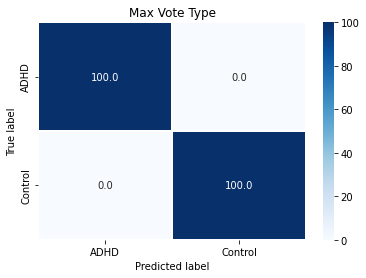

In [ ]:
# Loading the data
import numpy as np
X = np.load('X.npy')
Y = np.load('Y.npy')

print("X Shape:",X.shape)
print("Y shape:",Y.shape)
print(Y)
import scipy.io
SegmentPerSubject = scipy.io.loadmat('SegmentPerSubject', mat_dtype=True)
SegmentPerSubject = SegmentPerSubject['SegmentPerSubject']
SegmentPerSubject = np.array(SegmentPerSubject)
SegmentPerSubject = SegmentPerSubject.transpose()
print("shape Segments:", SegmentPerSubject.shape)

Group =[]
for i in range(SegmentPerSubject.shape[0]):
  for j in range(int(SegmentPerSubject[i])):
    Group.append(i)
Group = np.array(Group)
Group = np.expand_dims(Group, axis=1)
print(Group)
print("Group shape is:",Group.shape)

# Data Preparation(Spliting the data to 10 fold and pich one of them as the test se)
group_kfold1 = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=2023)
del X,Y,d_test, split_test, Group, group_kfold1
# Converting the labels to categirical
Y_test  = np.expand_dims(Y_test,axis=1)
Y_test  = np_utils.to_categorical(Y_test)
Y_train  = np.expand_dims(Y_train,axis=1)
Y_train  = np_utils.to_categorical(Y_train)
# initiating the model
model = TactileNet()
# Fitting the model
fit  = model.fit(X_train, Y_train,verbose = 2,shuffle=True, epochs=20,batch_size=32,validation_data=(X_test, Y_test))
### Calculating Sample accuracy ###
test_predict = model.predict(X_test)
test_sub_acc,test_sub_f2 = subject_classification(Y_test, test_predict, Group_test, calculate_type = 'max_vote')
test_sam_acc,test_sam_f2 = sample_classification(Y_test, test_predict)
################################################
print("test_sub_acc",test_sub_acc)
print("test_sub_f2",test_sub_f2)
print("test_sam_acc",test_sam_acc)
print("test_sam_f2",test_sam_f2)
###############################################
train_loss, train_acc = model.evaluate(X_train,Y_train)
test_loss, test_acc = model.evaluate(X_test, Y_test)